In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd


In [2]:
def K_calc(X1,X2,sigma):
    sub=X1-X2
    norm=np.dot(np.transpose(sub),sub) # sum xi**2
    K=np.exp(-norm/(2*sigma**2))
    return K[0,0]
    
### implementation of random train-test split
def data_split(Data,test_size):

    ### create a random permuation of the data indexes
    indexes = np.random.permutation(len(Data))
    ## define the test instances number
    test_instances = int(test_size*len(Data))


    train_data = []
    test_data = []
    ## parse each datum and place it on the train or test set
    ## taking into account its randomly computed permutation index
    for i in range(len(Data)):
        if(i > test_instances):
            train_data.append(np.array(Data[indexes[i]]))
        else:
            test_data.append(np.array(Data[indexes[i]]))

    return np.array(train_data), np.array(test_data)
# Cross validation

def cross_validation(x_train,y_train,x_test,y_test,gamma_values,sigma_values,N_fold):

    fold_size= (x_train.shape[1])//N_fold
    
    least_val_MSE=-1   
    avg_val_MSE_plot=[]      
                    
    for gamma in gamma_values:
        
        
        avg_val_MSE_plot_help=[]
        
        for sigma in sigma_values:
       
            
            avg_val_MSE=0
            avg_train_MSE=0
            
           # print('gamma id '+str(gamma_values.index(gamma))+', sigma id '+str(sigma_values.index(sigma)))
            
            for fold_id in range(N_fold): # work on first N fold
            
                # N folds
                x_val_cross = x_train[:,fold_id*fold_size:min((fold_id+1)*fold_size,x_train.shape[1])]
                x_train_cross = np.c_[x_train[:,0:fold_id*fold_size],x_train[:,(fold_id+1)*fold_size:x_train.shape[1]]]
                
                y_val_cross = y_train[:,fold_id*fold_size:min((fold_id+1)*fold_size,y_train.shape[1])]
                y_train_cross = np.c_[y_train[:,0:fold_id*fold_size],y_train[:,(fold_id+1)*fold_size:y_train.shape[1]]]            
        
                # Calculate K for this sigma and train folds
                l=x_train_cross.shape[1]
                K_train=np.zeros((l,l)) # K(xi,xj)
                
                
                for i in range(l):
                    for j in range(l):
                       xi=np.reshape(x_train_cross[:,i],(-1,1))
                       xj=np.reshape(x_train_cross[:,j],(-1,1))
                        
                       K_train[i,j]=K_calc(xi,xj,sigma) 
                       
                
                # Calculate K for this sigma and val fold, not square!
                l1=x_val_cross.shape[1]
                K_val=np.zeros((l,l1)) # K(xi,xj)
                
                for i in range(l):
                    for j in range(l1):
                        xi=np.reshape(x_train_cross[:,i],(-1,1))
                        xj=np.reshape(x_val_cross[:,j],(-1,1))  
                        
                        K_val[i,j]=K_calc(xi,xj,sigma)            
              
                    
                # TRAINING for train folds, get alpha* for this combination of gamma and sigma
                
                alpha=np.dot(np.linalg.inv(K_train+gamma*l*np.eye(l)),np.transpose(y_train_cross))
                    
                
                # VALIDATION on val fold for this combo, find MSE with Kval, and with Ktrain
                error=np.dot(np.transpose(alpha),K_val)-y_val_cross
                val_MSE=np.dot(error,np.transpose(error))/l1
                
               # print(val_MSE)
                
                error=np.dot(np.transpose(alpha),K_train)-y_train_cross
                train_MSE=np.dot(error,np.transpose(error))/l
                
               # print(val_MSE)
                
                # Average MSE val
                
                avg_val_MSE+= val_MSE
                avg_train_MSE+= train_MSE
               
                
                
            # Avg MSE and new best paramenters 
            
            avg_val_MSE = avg_val_MSE[0,0]
            avg_val_MSE /= N_fold
            avg_val_MSE_plot_help.append(avg_val_MSE)
         #   print('MSE = '+str(avg_val_MSE))      
            
            avg_train_MSE = avg_train_MSE[0,0]
            avg_train_MSE /= N_fold
            
          #  print('train MSE = '+str(avg_train_MSE))
    
           
            if least_val_MSE==-1 or least_val_MSE>avg_val_MSE:
               
                least_val_MSE=avg_val_MSE
                best_gamma=gamma
                best_sigma=sigma
    
        avg_val_MSE_plot.append(avg_val_MSE_plot_help) # add to a MSE val plot for all combo
        
    return best_gamma, best_sigma, avg_val_MSE_plot 
        
        

#  Retrain on whole train set for the best parameters

def MSE_train_test(x_train,x_test, y_train, y_test, best_gamma, best_sigma):
    
    # Calculate K for best param
    l3=x_train.shape[1]
    K_train=np.zeros((l3,l3))
    for i in range(l3):
        for j in range(l3):
            
            xi=np.reshape(x_train[:,i],(-1,1))
            xj=np.reshape(x_train[:,j],(-1,1))
            
            K_train[i,j] = K_calc(xi,xj,best_sigma)
            
    l4=x_test.shape[1]
    K_test=np.zeros((l3,l4))
    for i in range(l3):
        for j in range(l4):
            
            xi=np.reshape(x_train[:,i],(-1,1))
            xj=np.reshape(x_test[:,j],(-1,1))
            
            K_test[i,j]= K_calc(xi,xj,best_sigma)
            
    # Train
    
    alpha=np.dot(np.linalg.inv(K_train+best_gamma*l3*np.eye(l3)),np.transpose(y_train))
         
    # Calculate MSE train and test for best parameters
    
    error=np.dot(np.transpose(alpha),K_train)-y_train
    train_MSE=np.dot(error,np.transpose(error))/l3
    
    print('Train MSE = '+str(train_MSE[0,0]))
    
    error=np.dot(np.transpose(alpha),K_test)-y_test
    test_MSE=np.dot(error,np.transpose(error))/l4
    print('Test MSE = '+str(test_MSE[0,0]))
    
    return train_MSE[0,0], test_MSE[0,0]

In [3]:
dataset_file = 'C:/Users/aleks/Documents/UCL ML/Supervised/Assignment 1/BostonDataset.csv'

## load the dataset into a pandas dataframe
data_frame = pd.read_csv(dataset_file)

# convert dataframe to np array
data_array = data_frame.to_numpy()
print(data_array.shape)

# number of runs for each experiment (defined on the assignement paper)
N = 20
N_fold = 5
features_number = 13
test_split = round(((len(data_array)/3)/len(data_array)*100)/100,2)

train_data, test_data = data_split(data_array,test_split)#train_test_split(data_array,test_size=test_split)


x_train = train_data[:,:features_number-1].T
x_test = test_data[:,:features_number-1].T


y_train = np.reshape(train_data[:,(features_number-1)],(1,x_train.shape[1]))
y_test = np.reshape(test_data[:,(features_number-1)],(1,x_test.shape[1]))


(506, 13)


In [4]:
# Define values for parameters
gamma_values=np.flip(np.power(0.5,np.array(range(26,41)))).tolist()
sigma_values=np.power(2,np.arange(7.0, 13.5, 0.5)).tolist()

In [7]:
# Cross validation

best_gamma, best_sigma, avg_val_MSE_plot = cross_validation(x_train,y_train,x_test,y_test,gamma_values,sigma_values,N_fold)

gamma id 0, sigma id 0
MSE = 5029.44779915025
train MSE = 0.5043391982218728
gamma id 0, sigma id 1
MSE = 180.11748394870105
train MSE = 0.8957263213065992
gamma id 0, sigma id 2
MSE = 827.559267503332
train MSE = 1.3570287630980489
gamma id 0, sigma id 3
MSE = 6507.2261043958115
train MSE = 1.9040350944161575
gamma id 0, sigma id 4
MSE = 4071.642030006215
train MSE = 2.6666155296132463
gamma id 0, sigma id 5
MSE = 1434.6598086275876
train MSE = 3.8249975259931843
gamma id 0, sigma id 6
MSE = 87.03103112004325
train MSE = 5.182496458822848
gamma id 0, sigma id 7
MSE = 36.173019869028884
train MSE = 6.093968631403417
gamma id 0, sigma id 8
MSE = 43.31569987562889
train MSE = 6.868749061189679
gamma id 0, sigma id 9
MSE = 31.442319485450952
train MSE = 7.681166338140653
gamma id 0, sigma id 10
MSE = 24.24822719186409
train MSE = 8.515909812596087
gamma id 0, sigma id 11
MSE = 14.326204216172306
train MSE = 9.586540042826565
gamma id 0, sigma id 12
MSE = 15.401496573251137
train MSE = 11.

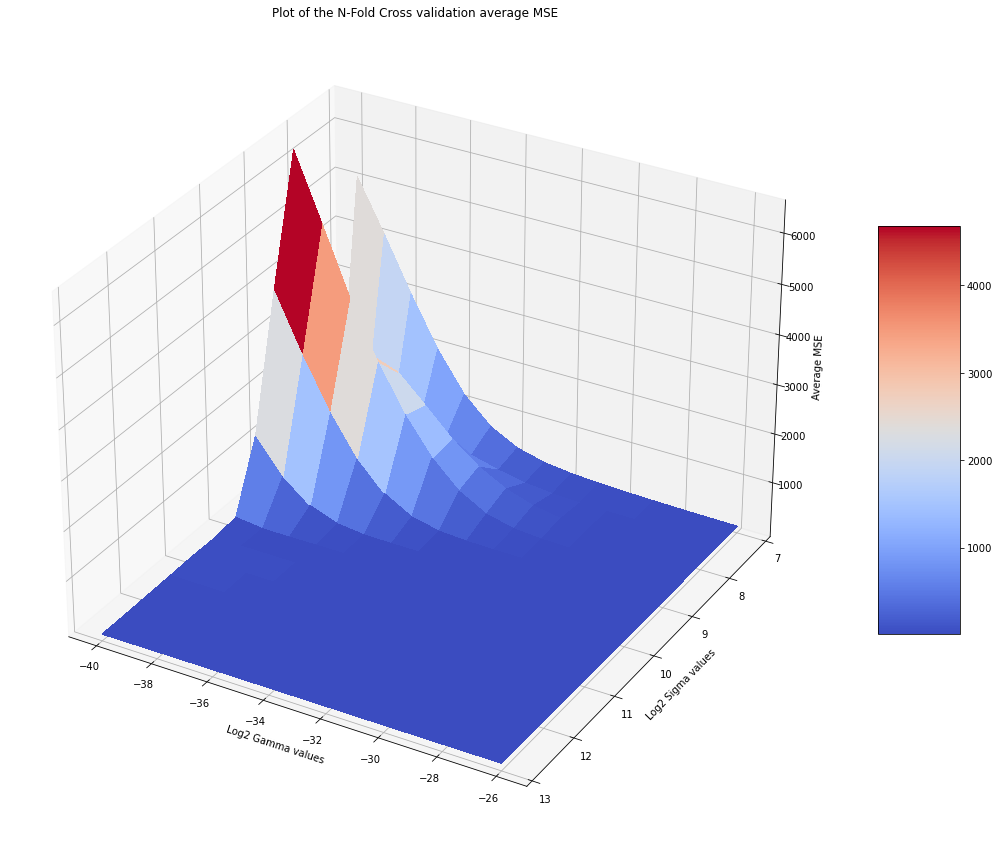

In [18]:
# Plot average MSE
Z=np.transpose(np.asarray(avg_val_MSE_plot))
X, Y = np.meshgrid(np.log2(gamma_values),np.log2(sigma_values))
fig = plt.figure(figsize = (20,15))
ax = fig.gca(projection='3d')
ax.set_xlabel("Log2 Gamma values")
ax.set_ylim(13,7)
ax.set_ylabel("Log2 Sigma values")
ax.set_zlabel("Average MSE")
ax.set_title("Plot of the N-Fold Cross validation average MSE")
surface = ax.plot_surface(X, Y, Z, cmap = cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surface, shrink=0.5, aspect=5)

In [8]:
# Retrain on whole dataset
train_MSE, test_MSE = MSE_train_test(x_train,x_test,y_train,y_test,best_gamma, best_sigma)

Train MSE = 8.389399267138046
Test MSE = 12.000328628215634


In [5]:
# Repeat procedure 20 times for different train test splits

MSEs_train=[]     
MSEs_test=[]
N_fold=5
for i in range(N):
    print('Run '+str(i+1))
    
    # Spliting
    train_data, test_data = data_split(data_array,test_size=test_split)
    
    # Reshaping the data set
    x_train = train_data[:,:features_number-1].T
    x_test = test_data[:,:features_number-1].T
    y_train = np.reshape(train_data[:,(features_number-1)],(1,x_train.shape[1]))
    y_test = np.reshape(test_data[:,(features_number-1)],(1,x_test.shape[1]))
    
    # Cross validation
    
    best_gamma, best_sigma, avg_val_MSE_plot = cross_validation(x_train,y_train,x_test,y_test,gamma_values,sigma_values,N_fold)
    # Training and testing
    trMSE, testMSE = MSE_train_test(x_train,x_test, y_train,y_test, best_gamma, best_sigma)
    
    MSEs_train.append(trMSE)
    MSEs_test.append(testMSE)
 
m_train = np.mean(MSEs_train)
s_train = np.std(MSEs_train)
m_test = np.mean(MSEs_test)
s_test = np.std(MSEs_test)
print(' ')
print('Train MSE = '+str(m_train)+' +- '+str(s_train))
print('Test MSE = '+str(m_test)+' +- '+str(s_test)) 
    

Run 1
Train MSE = 7.795795814458699
Test MSE = 14.903763771614747
Run 2
Train MSE = 9.336982225868647
Test MSE = 10.058438988211474
Run 3
Train MSE = 8.047044075835096
Test MSE = 13.660658608659963
Run 4
Train MSE = 7.815769925175939
Test MSE = 14.673617916228356
Run 5
Train MSE = 7.344650629448528
Test MSE = 15.928671060786359
Run 6
Train MSE = 7.967014553773162
Test MSE = 11.862616332558364
Run 7
Train MSE = 6.471255287515704
Test MSE = 15.179700067539317
Run 8
Train MSE = 10.551303886192784
Test MSE = 11.641425719710082
Run 9
Train MSE = 8.077381122097092
Test MSE = 11.395038496071118
Run 10
Train MSE = 8.979811776425892
Test MSE = 9.047477016082425
Run 11
Train MSE = 6.7418296137328895
Test MSE = 13.67205979602973
Run 12
Train MSE = 5.149205375087311
Test MSE = 12.963970725132558
Run 13
Train MSE = 8.88364121019309
Test MSE = 8.090122908172688
Run 14
Train MSE = 8.92130233885026
Test MSE = 14.813158230764001
Run 15
Train MSE = 10.424333528400446
Test MSE = 9.09738921267099
Run 16
T